In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_loc = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"
df = pd.read_csv(data_loc)

In [4]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
#Preparing the dataset
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [7]:
req_cols = df[['ram','storage', 'screen', 'final_price']]

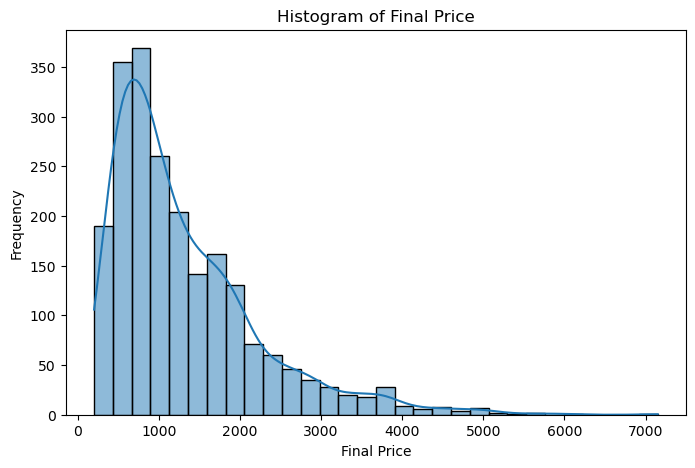

In [9]:
#check for longtail
plt.figure(figsize=(8, 5))
sns.histplot(req_cols['final_price'], bins=30, kde=True)
plt.title('Histogram of Final Price')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

In [10]:
#Missing Values
missing_vals = req_cols.isnull().sum()
missing_vals

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [12]:
#Median for RAM
median_ram = req_cols['ram'].median()
median_ram

16.0

In [13]:
np.random.seed(42)
n = len(req_cols)
n

2160

In [14]:
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [16]:
print(n_val)
print(n_test)
print(n_train)

432
432
1296


In [17]:
idx = np.arange(n)
np.random.shuffle(idx)

In [19]:
df_shuffled = req_cols.iloc[idx].reset_index(drop=True)

In [27]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [28]:
print(f'Train shape: {df_train.shape}, Validation shape: {df_val.shape}, Test shape: {df_test.shape}')

Train shape: (1296, 4), Validation shape: (432, 4), Test shape: (432, 4)


In [29]:
#Option 1: Filling missing values with zero
df_train_zero = df_train.fillna(0)
df_val_zero = df_val.fillna(0)

In [30]:
print(df_train_zero.head())

   ram  storage  screen  final_price
0   32     1000    15.6      1123.29
1    4       64    14.1       201.05
2   32     1000    14.0       997.74
3   16      512    13.3      1016.00
4   32     1000    16.0      2739.00


In [31]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [33]:
y_train = np.log1p(df_train['final_price'].values)

In [40]:
y_val = np.log1p(df_val['final_price'].values)

In [34]:
X_train_zero = df_train_zero[['ram', 'storage', 'screen']].values
y_train_zero = y_train

# Train the model
w_zero_0, w_zero_1 = train_linear_regression(X_train_zero, y_train_zero)

In [35]:
X_val_zero = df_val_zero[['ram', 'storage', 'screen']].values
y_pred_zero = np.column_stack([np.ones(X_val_zero.shape[0]), X_val_zero]).dot(np.concatenate(([w_zero_0], w_zero_1)))

In [37]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [47]:
# Calculate RMSE with zero filling NA
rmse_zero = rmse(y_val, y_pred_zero)
rmse_zero

0.42886353154744

In [50]:
# Calculate mean of 'Storage' from the training set
mean_storage = df_train['storage'].mean()

# Fill missing values with mean
df_train_mean = df_train.fillna(mean_storage)
df_val_mean = df_val.fillna(mean_storage)

# Prepare the input features
X_train_mean = df_train_mean[['ram', 'storage', 'screen']].values
y_train_mean = y_train

# Train the model
w_mean_0, w_mean_1 = train_linear_regression(X_train_mean, y_train_mean)

# Make predictions on the validation set
X_val_mean = df_val_mean[['ram', 'storage', 'screen']].values
y_pred_mean = np.column_stack([np.ones(X_val_mean.shape[0]), X_val_mean]).dot(np.concatenate(([w_mean_0], w_mean_1)))

# Calculate RMSE
rmse_mean = rmse(y_val, y_pred_mean)

In [48]:
rmse_with_zero = round(rmse_zero, 2)
rmse_with_zero

0.43

In [51]:
rmse_with_mean = round(rmse_mean,2)
rmse_with_mean

0.43

In [52]:

def train_reg_regression(X, y, alpha):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    n = X.shape[1]
    
    # Closed-form solution with regularization
    I = np.eye(n)
    XTX = X.T.dot(X) + alpha * I
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [53]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_results = {}

In [56]:
y_train = np.log1p(df_train_zero['final_price'].values)
y_val = np.log1p(df_val_zero['final_price'].values)

X_train = df_train_zero[['ram', 'storage', 'screen']].values
X_val = df_val_zero[['ram', 'storage', 'screen']].values

In [57]:
for r in r_values:
    w_ridge_0, w_ridge_1 = train_reg_regression(X_train, y_train, r)
    
    # Make predictions on the validation set
    X_val_with_bias = np.column_stack([np.ones(X_val.shape[0]), X_val])
    y_pred_ridge = X_val_with_bias.dot(np.concatenate(([w_ridge_0], w_ridge_1)))
    
    # Calculate RMSE
    rmse_value = np.sqrt(np.mean((y_val - y_pred_ridge) ** 2))
    rmse_results[r] = round(rmse_value, 2)

In [58]:
best_r = min(rmse_results, key=rmse_results.get)
best_rmse = rmse_results[best_r]

In [59]:
print("RMSE Results:", rmse_results)
print(f'Best r: {best_r}, RMSE: {best_rmse}')

RMSE Results: {0: 0.43, 0.01: 0.43, 0.1: 0.43, 1: 0.43, 5: 0.46, 10: 0.51, 100: 0.67}
Best r: 0, RMSE: 0.43


In [60]:
#Q.5
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [61]:
seed_values = range(10)
rmse_scores = []

In [62]:
for seed in seed_values:
    np.random.seed(seed)

    # Shuffle and split the dataset
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # Fill missing values with 0
    df_train_zero = df_train.fillna(0)
    df_val_zero = df_val.fillna(0)

    # Prepare the target variable
    y_train = np.log1p(df_train_zero['final_price'].values)
    y_val = np.log1p(df_val_zero['final_price'].values)

    # Prepare input features
    X_train = df_train_zero[['ram', 'storage', 'screen']].values
    X_val = df_val_zero[['ram', 'storage', 'screen']].values

    # Train the model
    w_zero_0, w_zero_1 = train_linear_regression(X_train, y_train)

    # Make predictions on the validation set
    X_val_with_bias = np.column_stack([np.ones(X_val.shape[0]), X_val])
    y_pred_zero = X_val_with_bias.dot(np.concatenate(([w_zero_0], w_zero_1)))

    # Calculate RMSE and store it
    rmse_value = np.sqrt(np.mean((y_val - y_pred_zero) ** 2))
    rmse_scores.append(rmse_value)

In [63]:
# Calculate standard deviation of RMSE scores
std_rmse = round(np.std(rmse_scores), 3)

In [64]:
print("RMSE Scores for different seeds:", rmse_scores)
print(f'Standard deviation of RMSE scores: {std_rmse}')

RMSE Scores for different seeds: [0.4300421569415628, 0.4520794495247191, 0.44626255742365506, 0.446451556572719, 0.4199805419364104, 0.42545763234186906, 0.4488322872388542, 0.43091598759041205, 0.4428849183283809, 0.40840334262398703]
Standard deviation of RMSE scores: 0.014


In [65]:
#q6
np.random.seed(9)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [66]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_combined = pd.concat([df_train, df_val], ignore_index=True)

In [67]:
df_combined.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [68]:
y_combined = np.log1p(df_combined['final_price'].values)
y_test = np.log1p(df_test['final_price'].values)

In [69]:
X_combined = df_combined[['ram', 'storage', 'screen']].values
X_test = df_test[['ram', 'storage', 'screen']].values

In [70]:
def train_regression(X, y, alpha):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    n = X.shape[1]

    # Closed-form solution with regularization
    I = np.eye(n)
    XTX = X.T.dot(X) + alpha * I
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [72]:
r = 0.001
w_ridge_0, w_ridge_1 = train_regression(X_combined, y_combined, r)

In [73]:
X_test_with_bias = np.column_stack([np.ones(X_test.shape[0]), X_test])
y_pred_test = X_test_with_bias.dot(np.concatenate(([w_ridge_0], w_ridge_1)))

In [74]:
rmse_value = rmse(y_test, y_pred_test)

In [75]:
print(f'RMSE on test dataset: {round(rmse_value, 2)}')

RMSE on test dataset: 0.46
